<a href="https://colab.research.google.com/github/sebastianJamesMI/Fellowship_AI_IMDB/blob/main/Sentiment_Analysis_IMDB_BERT_Embedding_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses the IMDB dataset compiled by Andrew Maas (see 
http://ai.stanford.edu/~amaas/data/sentiment/).

- The objective is to classify movie reviews as positive or negative. The original reviews were rated on a scale from 1 to 10. For Binary Classification, anything with <= 4 was classfed as negative and anything with >= 7 stars were classified as positive. 


############################################################################

I use different strategies to perform this classification task starting with a simple RNN model (LSTM) then using more complex models. 



############################################################################


This notebook uses a LSTM model and the BERT tokenizer, but does not use the BERT pre-trained weights. It trains the weights from scratch. 

This notebook references the following sources:


1. NLP course on Udemy by Martin Jocqueviel: https://www.udemy.com/course/modern-nlp/

2. Data reading and downloading, Aaron Kub: 
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

3. Data Reading and Downloading: Georgios Drakos: https://gdcoder.com/sentiment-clas/

4. Word Tokenization: Coursera Deep learning NLP courses by Andrew Ng


Download the data from http://ai.stanford.edu/~amaas/data/sentiment/

In another notebook I downloaded the data and saved them as train.csv and test.csv files

In [46]:
!pip install bert-for-tf2   ## not the official BERT source
!pip install sentencepiece

In [104]:
## Import Dependencies
import numpy as np
import pandas as pd
from glob import glob
import random
import os
import re
import string
import math

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Conv1D, GlobalMaxPooling1D, Input

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
## install requirements to use tensorflow/models repository
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git
!pip install -Uqr models/official/requirements.txt

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1382 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 27.86 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

     |████████████████████████████████| 6.6MB 9.3MB/s 
     |████████████████████████████████| 225kB 56.4MB/s 
     |████████████████████████████████| 15.3MB 213kB/s 
     |████████████

In [107]:
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


In [75]:
import tensorflow_hub as hub #site where pre-trained models are uploaded. will be needed when we need to download BERT weights
import bert

In [114]:
## Read in train and test files, we can use these filesn for future notebooks
train_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Projects/FellowshipAI/test.csv')

In [115]:
print(train_df.shape)
print(test_df.shape)

(25000, 2)
(25000, 2)


In [116]:
train, val = train_test_split(train_df, test_size = 0.2)

In [117]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train['text'].values, train['label'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((val['text'].values, val['label'].values))

In [118]:
## Text data needs to be converted to numerical data using tokenizing
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable = True)  ## BERT layer, we are not training the weights
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()  ## access to the vocab file as numpy
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case= do_lower_case)

In [119]:
label_list = [0,1] ### Label categories

max_seq_length = 128 #####Allows for 512, for this we are going with 128, max sequence length.

train_batch_size = 32

In [120]:
def to_features(text, label, label_list = label_list, max_seq_length = max_seq_length, tokenizer = tokenizer):
    example = classifier_data_lib.InputExample(guid = None, 
                                                text_a = text.numpy(),
                                                text_b = None,
                                                label = label.numpy())
    
    feature = classifier_data_lib.convert_single_example(0,example, label_list, max_seq_length, tokenizer)

    
    return(feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [121]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_features, inp = [text, label],
                                                                    Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids

    }

    return(x, label_id)


In [122]:
### BERt requires input_ids, input_mask, input_type_ids

with tf.device('cpu:0'):
        #train
        train_data = (train_data.map(to_feature_map,
                        num_parallel_calls = tf.data.experimental.AUTOTUNE)
        .shuffle(1000)
        .batch(32, drop_remainder = True)
        .prefetch(tf.data.experimental.AUTOTUNE))

        #validation

        valid_data = (valid_data.map(to_feature_map,
                        num_parallel_calls = tf.data.experimental.AUTOTUNE)
        .batch(32, drop_remainder = True)
        .prefetch(tf.data.experimental.AUTOTUNE))

In [123]:
# resulting tf.data.Datasets now will return pairs
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [124]:
def create_model():
      input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                            name="input_word_ids")
      input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_mask")
      input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                          name="input_type_ids")
      pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

      drop = tf.keras.layers.Dropout(0.4)(pooled_output)
      output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(drop)
      
      model = tf.keras.Model(
          inputs = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
          },
          outputs = output)
      return model

In [125]:
### Fine tune BERT for text classification

model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5), 
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_7 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

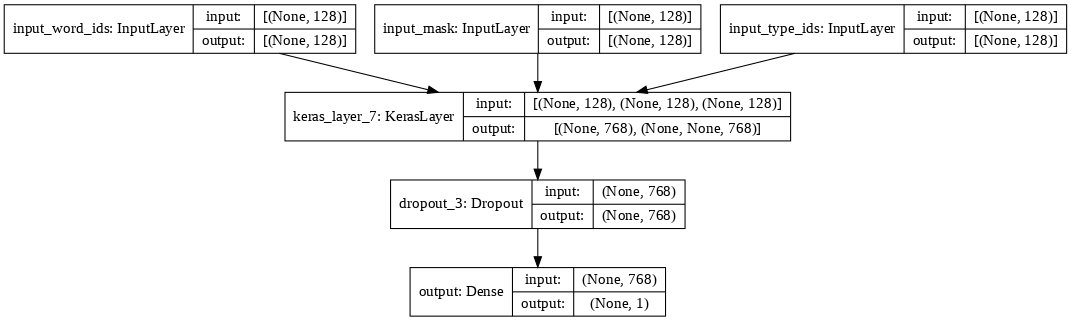

In [126]:
tf.keras.utils.plot_model(model = model, show_shapes = True, dpi = 76)

In [127]:
#Train_model
epochs = 5
history = model.fit(train_data, 
                    validation_data = valid_data, 
                    epochs = epochs,
                    verbose = 1)

Epoch 1/5
625/625 [==============================] - 555s 859ms/step - loss: 0.4339 - binary_accuracy: 0.7855 - val_loss: 0.2677 - val_binary_accuracy: 0.8886
Epoch 2/5
625/625 [==============================] - 548s 869ms/step - loss: 0.1892 - binary_accuracy: 0.9254 - val_loss: 0.3277 - val_binary_accuracy: 0.8846
Epoch 3/5
625/625 [==============================] - 548s 869ms/step - loss: 0.0687 - binary_accuracy: 0.9761 - val_loss: 0.4626 - val_binary_accuracy: 0.8816
Epoch 4/5
625/625 [==============================] - 548s 870ms/step - loss: 0.0260 - binary_accuracy: 0.9925 - val_loss: 0.4917 - val_binary_accuracy: 0.8768
Epoch 5/5
625/625 [==============================] - 548s 869ms/step - loss: 0.0196 - binary_accuracy: 0.9939 - val_loss: 0.5763 - val_binary_accuracy: 0.8860


Evaluation

In [135]:
##preparing the test dataset
test_data = tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['label'].values))
test_data = (test_data.map(to_feature_map,
                        num_parallel_calls = tf.data.experimental.AUTOTUNE)
        .shuffle(1000)
        .batch(32, drop_remainder = True)
        .prefetch(tf.data.experimental.AUTOTUNE))


In [136]:
results = model.evaluate(test_data)

781/781 [==============================] - 228s 286ms/step - loss: 0.5854 - binary_accuracy: 0.8798


In [137]:
print(f'The Accuracy of model on the test dataset is: {results[1]:.2f}')

The Accuracy of model on the test dataset is: 0.88
